## Description

-- Evaluation de la similarité sémantique entre 2 phrases --  
  
Suite de mots -> suite de vecteurs (nn.Embeddings, Glove)  
Suite de vecteurs -> vecteur de phrase (LSTM)  
(x2)  
Vecteurs de phrases -> vecteur comparatif (produit, distance euclidienne)  
Vecteur comparatif -> score de similarité (couche linéaire)

Environnement
=============

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data import Field, ReversibleField, TabularDataset, Iterator, BucketIterator

['tsv_with_metrics.txt', 'tsv.txt']


In [2]:
import torch
# torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Lecture des données
===================
torchtext doc : https://torchtext.readthedocs.io/en/latest/

In [5]:
def tokenize(text):
    return text.split()

def proc_float(value):
    return float(value)

def proc_int(value):
    return int(value)

TEXT = Field(sequential=True, lower=True, tokenize=tokenize)
FLOAT = Field(sequential=False, use_vocab=False, dtype=torch.float, preprocessing=proc_float) 
INTEGER = Field(sequential=False, use_vocab=False, preprocessing=proc_int)

df = TabularDataset("../input/sentence-relatedness/SICK_train_logistic.txt", "tsv", skip_header=True,
                            fields=[('idx',INTEGER),('sentA',TEXT),('sentB',TEXT),('Relatedness',FLOAT)])

df_train, df_dev = df.split(split_ratio=0.8)
TEXT.build_vocab(df_train)

# Prints out the first few lines of the train set
for elt in df_train[:5]:
    print(elt.idx, ' '.join(elt.sentA), '||', ' '.join(elt.sentB), elt.Relatedness)
print()

# load test set
df_test = TabularDataset("../input/sentence-relatedness/SICK_test.txt", "tsv", skip_header=True,
                            fields=[('idx',INTEGER),('sentA',TEXT),('sentB',TEXT)])

# Prints out the first few lines of the test set
for elt in df_test[:5]:
    print(elt.idx,' '.join(elt.sentA),'||',' '.join(elt.sentB))

8206 a bride with a black veil is looking down || a woman is looking down and is wearing a wedding veil 0.76
2651 the man is slicing vegetables || there is no woman slicing a potato 0.5
2650 the man is slicing vegetables || a woman is cutting a potato 0.6
5149 a lemur is hanging on a cord || a lemur is hanging on a rope 0.8800000000000001
3985 a tomato is being sliced by a woman || a woman is peeling a potato 0.6599999999999999

6 there is no boy playing outdoors and there is no man smiling || a group of kids is playing in a yard and an old man is standing in the background
7 a group of boys in a yard is playing and a man is standing in the background || the young boys are playing outdoors and the man is smiling nearby
8 a group of children is playing in the house and there is no man standing in the background || the young boys are playing outdoors and the man is smiling nearby
10 a brown dog is attacking another animal in front of the tall man in pants || a brown dog is attacking anot

Classification
==============

In [63]:
class ParaphraseClassifier(nn.Module):
    
    def __init__(self, hidden_dim, embedding_dim):
       
        super(ParaphraseClassifier, self).__init__()
       
        self.hidden_dim    = hidden_dim
        self.embedding_dim = embedding_dim
        self.embedding     = nn.Embedding(len(TEXT.vocab), embedding_dim)
        self.lstm          = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, bidirectional=True)
        self.Wadd          = nn.Linear(2*hidden_dim, hidden_dim)   
        self.Wtimes        = nn.Linear(2*hidden_dim, hidden_dim)
        self.Wout          = nn.Linear(hidden_dim, 1)
        
        
    def use_glove_embeddings(self):
        """
        1 - charge les embeddings dans un dictionnaire {mot: embedding}
        2 - récupère les embeddings correspondants au vocabulaire du corpus
        3 - stocke les embeddings au format attendu par pytorch = liste d'embeddings (matrice) où l'indice correspond au mot dans le vocabulaire
        4 - charge les embeddings dans la classe pytorch
        """
        # 1 - load Glove
        embeddings_dict = {}
        with open("../input/glove-global-vectors-for-word-representation/glove.6B.50d.txt", 'r') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], "float32")
                embeddings_dict[word] = vector
        
        # 2,3 - adapt to corpus
        weights_matrix = []
        words_found = 0
        vocab = [TEXT.vocab.itos[i] for i in range(len(TEXT.vocab))]
        for i, word in enumerate(vocab):
            try: 
                weights_matrix.append(embeddings_dict[word])
                words_found += 1
            # pour les rares mots qui ne sont pas dans Glove, on laisse un vecteur au hasard
            except KeyError:
                weights_matrix.append(np.random.normal(scale=0.6, size=(50, )))
        weights_matrix = torch.FloatTensor(weights_matrix).to(device)
                
        # 4 - create layer
        num_embeddings, embedding_dim = weights_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(weights_matrix)
        # bloque l'entraînement des embeddings
        self.embedding.weight.requires_grad = False


    def forward(self, xinputA, xinputB):
        """
        Args:
            xinputA is a sequence of word indexes
            xinputB is a sequence of word indexes
        The forward method also works for batched input.       
        """
        ##details for dimensionalities
        #embeddings
        #  input : batch_size x seq_length
        #  output: batch-size x seq_length x embedding_dimension
        #lstm
        #  input : seq_length x batch_size x embedding_size
        #  output: seq_length x batch_size x hidden_size  (for the sequence)
        #  output: batch_size x hidden_size (for the last hidden/cell state)
        xembeddedA                 = self.embedding(xinputA)                                                #catches embedding vectors
        lstm_outA, (hiddenA,cellA) = self.lstm(xembeddedA.view(len(xinputA), -1, self.embedding_dim), None) #-1 is a wildcard (here we let pytorch guess batch size)
       
        xembeddedB                 = self.embedding(xinputB)                                                #catches embedding vectors
        lstm_outB, (hiddenB,cellB) = self.lstm(xembeddedB.view(len(xinputB), -1, self.embedding_dim), None)
        
        hiddenA = torch.cat((hiddenA[0], hiddenA[1]), -1)
        hiddenB = torch.cat((hiddenB[0], hiddenB[1]), -1)
#         print(hiddenA.shape)
#         print(hiddenA[0].shape)
       
        #hiddenA = hiddenA.view(-1, self.hidden_dim * 2)
        #hiddenB = hiddenB.view(-1, self.hidden_dim * 2)       
        #merge sentence representations
        hiddenT = hiddenA * hiddenB
        hiddenD = torch.abs(hiddenA - hiddenB)
        hidden  = torch.tanh(self.Wtimes(hiddenT) + self.Wadd(hiddenD))
        return torch.sigmoid(self.Wout(hidden))
    
    
    def train(self, train_set, dev_set, epochs, metrics, learning_rate=0.001):
        
        loss_func = nn.BCELoss() 
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        # - la vitesse d'entraînement est décuplée en passant de batchs de 1 à des batchs de 64
        # - BucketIterator : rassemble les séquences de tailles similaires dans les batchs pour limiter le padding
        train_iterator, dev_iterator = BucketIterator.splits((train_set, dev_set), batch_sizes=(64,64), device=device, 
            sort_key=lambda x:len(x.sentA), sort=False, sort_within_batch=False, repeat=False, shuffle=True)
        
        t = time.time()
        for e in range(epochs):
            train_BCE_loss = 0
            train_custom_loss = 0
            nb_batch = 0
            for i, batch in enumerate((train_iterator)):
                nb_batch += 1
                xvecA, xvecB, yRelness = batch.sentA, batch.sentB, batch.Relatedness
                self.zero_grad()
                prob = self.forward(xvecA, xvecB).squeeze()
                loss = loss_func(prob, yRelness)
                loss.backward()
                optimizer.step()
                train_BCE_loss += loss.item()
                train_custom_loss += torch.mean(torch.abs(prob-yRelness)).item()
            
            avg_train_BCE_loss = train_BCE_loss/nb_batch
            metrics["train"]["BCE"].append(avg_train_BCE_loss)
            
            avg_train_custom_loss = train_custom_loss/nb_batch
            metrics["train"]["custom"].append(avg_train_custom_loss)
            
            val_BCE_loss = 0
            val_custom_loss = 0
            nb_batch = 0
            for i, batch in enumerate((dev_iterator)):
                nb_batch += 1
                xvecA, xvecB, yRelness = batch.sentA, batch.sentB, batch.Relatedness
                prob = self.forward(xvecA, xvecB).squeeze()
                loss = loss_func(prob, yRelness)
                val_BCE_loss += loss.item()
                val_custom_loss += torch.mean(torch.abs(prob-yRelness)).item()
            
            avg_val_BCE_loss = val_BCE_loss/nb_batch
            metrics["val"]["BCE"].append(avg_val_BCE_loss)
            
            avg_val_custom_loss = val_custom_loss/nb_batch
            metrics["val"]["custom"].append(avg_val_custom_loss)
            
            print("Epoch", e, "train loss =", avg_train_BCE_loss, "val loss =", avg_val_BCE_loss)
                
        print(epochs,"epochs,",time.time()-t,'s')
        
            
    def run_test(self,test_set):

        # make predictions
        test_iterator = Iterator(test_set, batch_size=1, device=device, sort=False, 
                                 sort_within_batch=False, repeat=False, shuffle=False)
        
        predictions = list()
        idx = list()
        for elt in test_iterator:
            xvecA, xvecB = elt.sentA, elt.sentB
            relness = self.forward(xvecA, xvecB).squeeze()
            score = relness.item() *4 +1
            predictions.append(score)
            idx.append(elt.idx.item())

        to_df = {'pairID': idx, 'Relatedness': predictions}
        df = pd.DataFrame(to_df)
        print(df)
        df.to_csv('results.csv', index=False)

In [64]:
pc = ParaphraseClassifier(150, 50) # (hidden_dim, embedding_dim)

In [65]:
pc.to(device)

ParaphraseClassifier(
  (embedding): Embedding(2122, 50)
  (lstm): LSTM(50, 150, bidirectional=True)
  (Wadd): Linear(in_features=300, out_features=150, bias=True)
  (Wtimes): Linear(in_features=300, out_features=150, bias=True)
  (Wout): Linear(in_features=150, out_features=1, bias=True)
)

In [66]:
pc.use_glove_embeddings()

In [67]:
metrics = {"train":{"BCE":[], "custom":[]}, 
           "val":{"BCE":[], "custom":[]}}

pc.train(df_train, df_dev, 100, metrics)

Epoch 0 train loss = 0.6162157173742328 val loss = 0.6028264959653219
Epoch 1 train loss = 0.5856055408193354 val loss = 0.577472714583079
Epoch 2 train loss = 0.5627878684746591 val loss = 0.5648101051648458
Epoch 3 train loss = 0.5509693528476515 val loss = 0.5521454811096191
Epoch 4 train loss = 0.5440174299373961 val loss = 0.555815847714742
Epoch 5 train loss = 0.5380932385461372 val loss = 0.5560440262158711
Epoch 6 train loss = 0.5325222261119307 val loss = 0.558320689201355
Epoch 7 train loss = 0.5286400469771603 val loss = 0.5536218881607056
Epoch 8 train loss = 0.5249742640737902 val loss = 0.5535623510678609
Epoch 9 train loss = 0.5233812269411589 val loss = 0.5545944412549336
Epoch 10 train loss = 0.5216379322503742 val loss = 0.5619720657666524
Epoch 11 train loss = 0.5179075039269632 val loss = 0.5463512579600016
Epoch 12 train loss = 0.5167743438168576 val loss = 0.5561238050460815
Epoch 13 train loss = 0.5147453891603571 val loss = 0.5472929696242015
Epoch 14 train loss

<function matplotlib.pyplot.show(*args, **kw)>

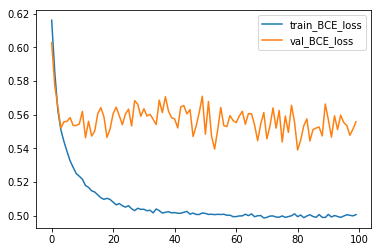

In [68]:
from matplotlib import pyplot as plt
plt.plot(metrics["train"]["BCE"], label='train_BCE_loss')
plt.plot(metrics["val"]["BCE"],label='val_BCE_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

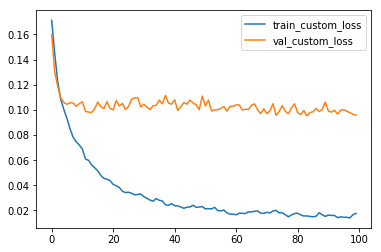

In [69]:
plt.plot(metrics["train"]["custom"], label='train_custom_loss')
plt.plot(metrics["val"]["custom"],label='val_custom_loss')
plt.legend()
plt.show

In [70]:
pc.run_test(df_test)

In [74]:
def vectorize(sentence):
    sentence = sentence.split()
    return torch.tensor([TEXT.vocab.stoi[w] for w in sentence]).to(device)

In [72]:
def inference(vecA, vecB, pc):
    relness = pc.forward(vecA,vecB).squeeze()
    score = relness.item()
    print(score)

In [75]:
sentA = "it is raining today"
vecA = vectorize(sentA)
sentB = "there was an economy crisis in 2008"
vecB = vectorize(sentB)
inference(vecA, vecB, pc)

0.5251803398132324
